# Using CLIPSeg with Hugging Face Transformers

Using Hugging Face Transformers, you can easily download and run a pre-trained CLIPSeg model on your images. Let’s start by installing transformers.

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.3 MB/s eta 0:00:00


In [ ]:
import requests
from PIL import Image
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation


To download the model, simply instantiate it.

In [ ]:

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

Now we can load an image to try out the segmentation. We'll choose a picture of a delicious breakfast taken by [Calum Lewis](https://unsplash.com/@calumlewis).

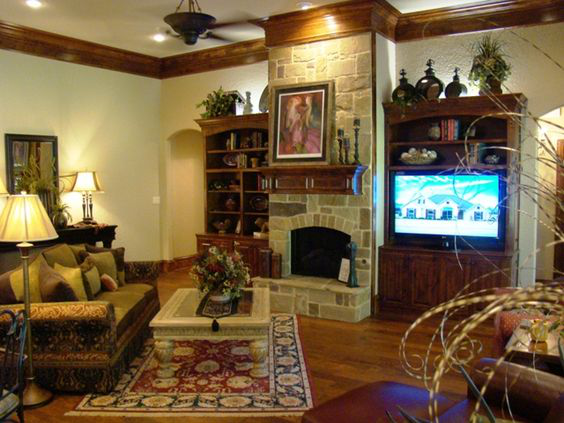

In [ ]:


# URL of the image to load
url = "https://i.pinimg.com/564x/f9/92/79/f992799d34ed72382794c1abcebeb50f.jpg"

# Send a GET request to the image URL and store the response
response = requests.get(url, stream=True)

# Open the response content as an image using PIL
image = Image.open(response.raw)

# Display the image
image.show()


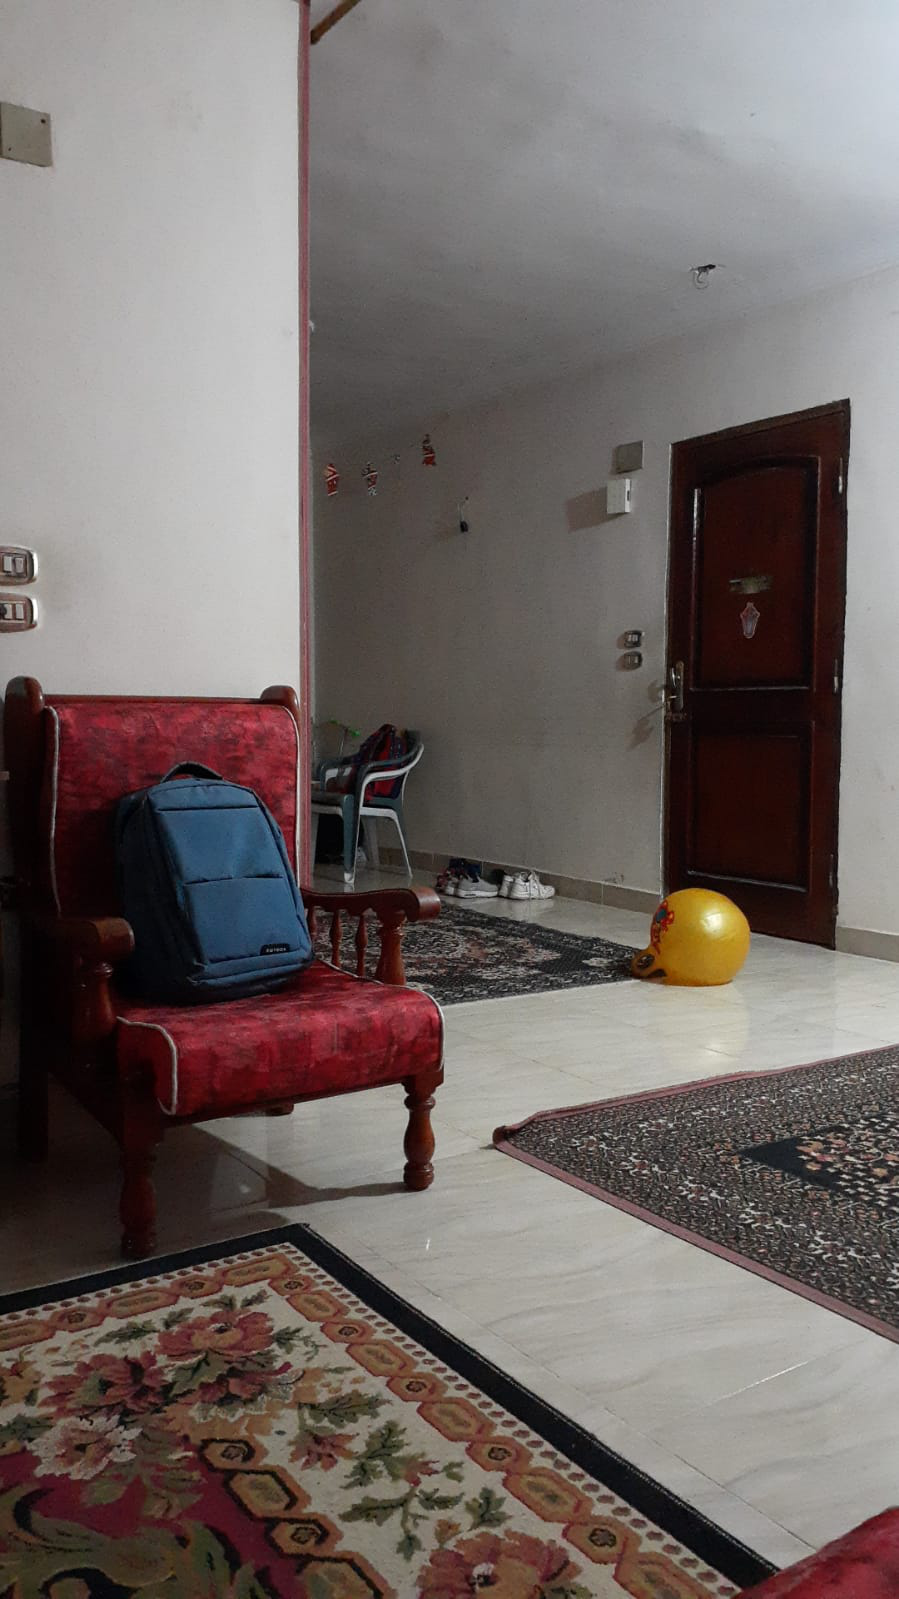

In [ ]:
image = Image.open("/content/home.jpg")
image.show()

## Model prediction on Text prompts

Let’s start by defining some text categories we want to segment.

In [ ]:
# prompts = ["tv","sofa","flowers","painting","lamps"]
prompts = ["backbag","yellow balloon","pair of shoes","door","red chair"]

In [ ]:


image = image.convert('RGB')

# Convert to PyTorch tensor
tensor = torch.tensor(np.array(image)).permute(2, 0, 1).unsqueeze(0).float()

Now that we have our inputs, we can process them and input them to the model.

In [ ]:

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)
masks = torch.sigmoid(preds).squeeze(1)
maskss = outputs.logits

## Different visualizations

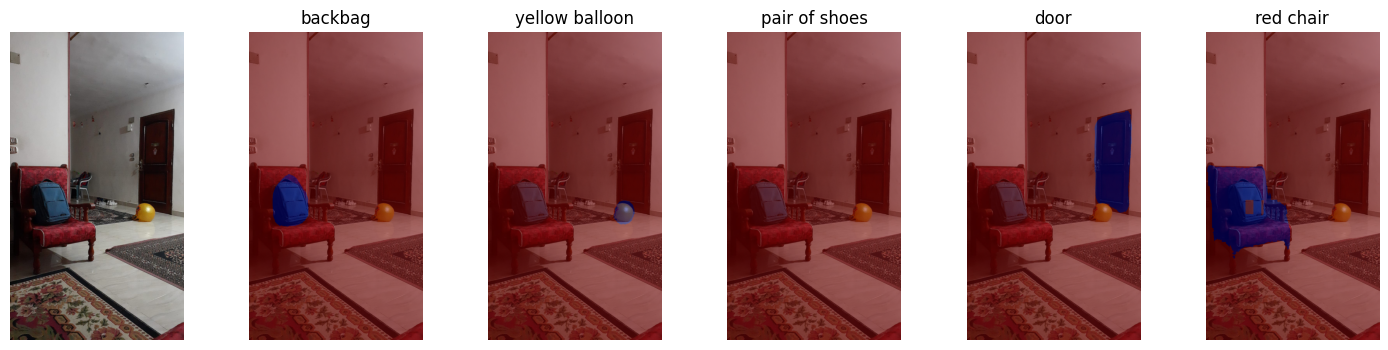

In [ ]:


fig, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[ax[i].axis('off') for i in range(len(prompts) + 1)]
ax[0].imshow(image)

for i, prompt in enumerate(prompts):
    # get the predicted heat map
    pred_heatmap = torch.sigmoid(preds[i][0])

    # resize the heat map to the original image size
    pred_heatmap = pred_heatmap.cpu().numpy()
    pred_heatmap = cv2.resize(pred_heatmap, (image.width, image.height))

    # threshold the heat map to remove noise
    threshold = 0.5
    pred_heatmap[pred_heatmap < threshold] = 0
    pred_heatmap[pred_heatmap >= threshold] = 1

    # apply the heat map on the original image
    heatmap = np.uint8(255 * pred_heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(np.array(image), 0.5, heatmap, 0.5, 0)

    # display the overlayed image
    ax[i+1].imshow(overlayed_img)
    ax[i+1].set_title(prompt)
    
plt.show()


In [ ]:
# print(preds)

Finally, let’s visualize the output.

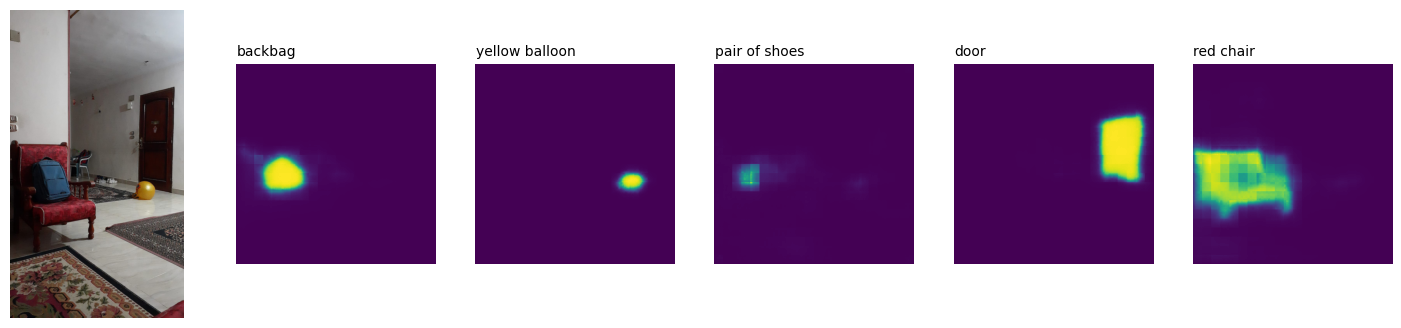

In [ ]:

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

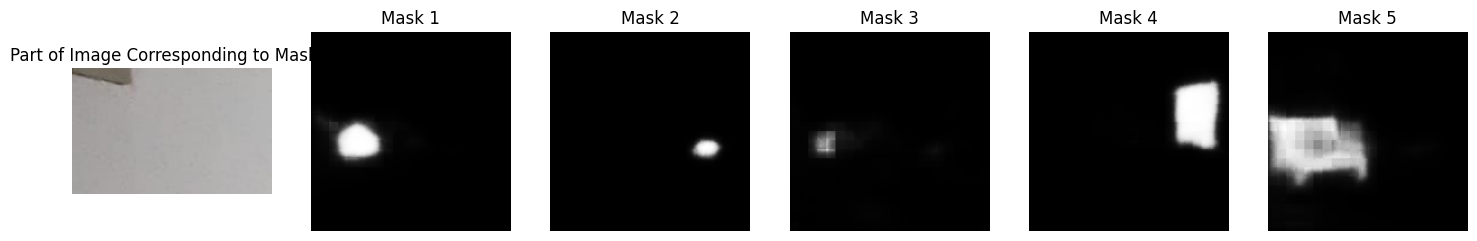

In [ ]:
fig, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))

for i in range(len(prompts)):
    mask = masks[i]
    ax[i+1].imshow(mask, cmap='gray')
    ax[i+1].axis('off')
    ax[i+1].set_title(f"Mask {i+1}")

    mask = mask.numpy()
    mask = np.where(mask > 0.5, 1, 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) > 0:
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        contour = contours[max_index]

        x, y, w, h = cv2.boundingRect(contour)
        img_cropped = np.array(image.crop((x, y, x+w, y+h)))
        ax[0].imshow(img_cropped)
        ax[0].axis('off')
        ax[0].set_title(f"Part of Image Corresponding to Mask {i+1}")

plt.show()

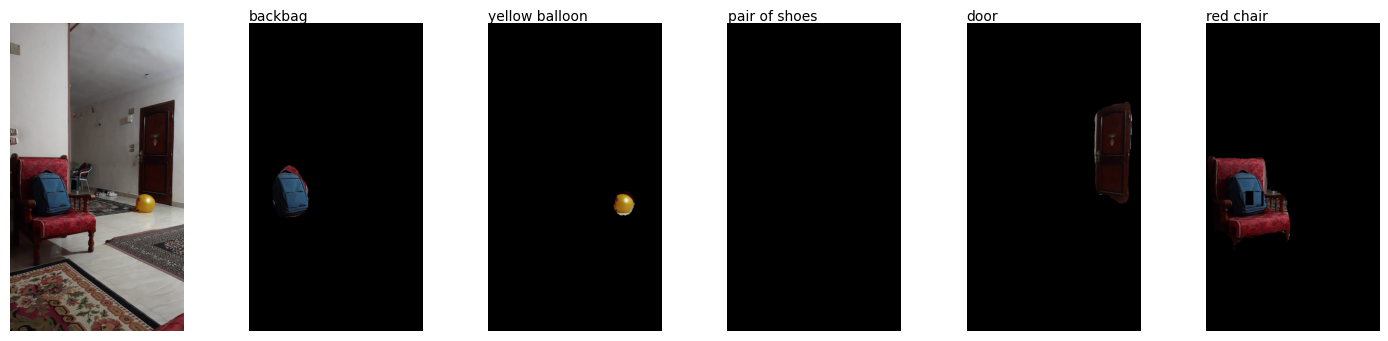

In [ ]:
# Display the original image and the heat map masks
fig, axs = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
axs[0].imshow(image)
axs[0].axis('off')
for i, prompt in enumerate(prompts):
    # Get the heat map for the prompt
    heat_map = torch.sigmoid(preds[i][0]).detach().cpu().numpy()
    # Resize the heat map to match the original image size
    heat_map_resized = cv2.resize(heat_map, (image.size[0], image.size[1]))
    # Apply a threshold to the heat map to get the mask
    mask = (heat_map_resized > 0.5).astype(np.uint8)
    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(np.array(image), np.array(image), mask=mask)
    # Display the masked image
    axs[i+1].imshow(masked_image)
    axs[i+1].axis('off')
    axs[i+1].text(0, -15, prompt)
plt.show()

# **Depth estimation**

---




In [ ]:
from transformers import DPTImageProcessor, DPTForDepthEstimation


In [ ]:
processor2 = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model2 = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Testing the mask from Clipseg objects detected on the second object(idx 1) from prompt list

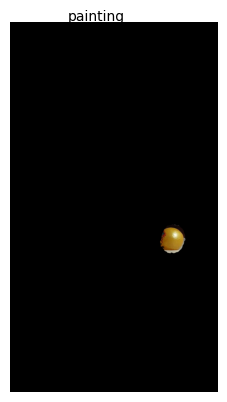

In [ ]:
# Get the heat map for the prompt
heat_map = torch.sigmoid(preds[1][0]).detach().cpu().numpy()
# Resize the heat map to match the original image size
heat_map_resized = cv2.resize(heat_map, (image.size[0], image.size[1]))
# Apply a threshold to the heat map to get the mask
mask = (heat_map_resized > 0.5).astype(np.uint8)
# Apply the mask to the original image
masked_image = cv2.bitwise_and(np.array(image), np.array(image), mask=mask)
plt.axis('off')
plt.text(250, -10, "painting")
plt.imshow(masked_image)

0
1


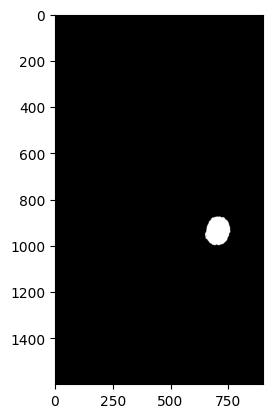

In [ ]:
plt.imshow(mask,cmap='gray')
print(np.min(mask))
print(np.max(mask))

## Estimating the Depth

In [ ]:
inputs = processor2(images=image, return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs2 = model2(**inputs)
    predicted_depth = outputs2.predicted_depth

In [ ]:
predicted_depth.shape

torch.Size([1, 384, 384])

In [ ]:
# interpolate to original size
prediction2 = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

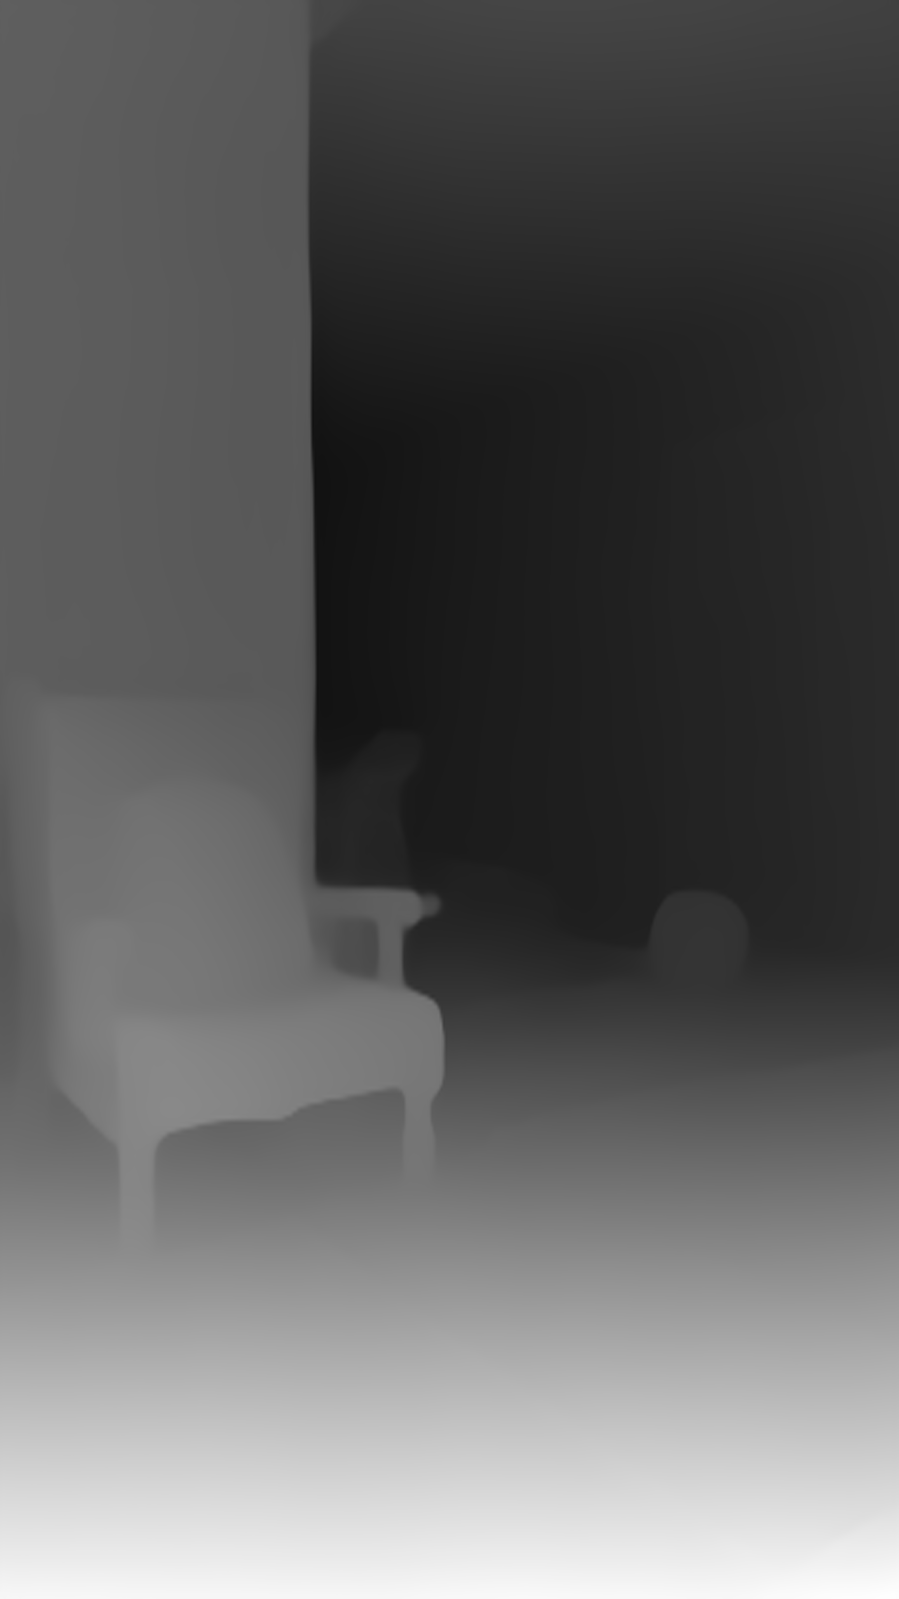

In [ ]:
# visualize the prediction
output2 = prediction2.squeeze().cpu().numpy()
formatted = (output2 * 255 / np.max(output2)).astype("uint8")
depth = Image.fromarray(formatted)
depth

In [ ]:
# Apply the mask to the depth image
# depth_masked = cv2.bitwise_and(formatted, formatted, mask=mask)
print(np.shape(depth))

(1599, 899)


## Applying and preprocessing the input `mask` of Clipseg on the output `depth` image of DPT

(1599, 899)


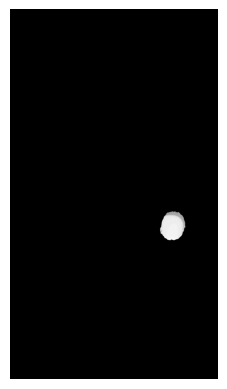

In [ ]:
# Apply the mask to the depth image
#print(np.min(depth))
#print(np.max(depth))
masked_depth = cv2.bitwise_and(np.array(depth), np.array(depth), mask=mask)

# Display the masked depth image
print(np.shape(masked_depth))
plt.imshow(masked_depth, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
mask=np.uint8(mask)*255
print(np.unique(mask))
# plt.imshow(mask,cmap='gray')

[  0 255]


In [ ]:
print(np.unique(mask))

x1,x2=np.where(mask==255)
print(len(x1))
print(len(x2))
depth=np.array(depth)
depth=np.expand_dims(depth,axis=2)

[  0 255]
10370
10370


(1599, 899, 1)


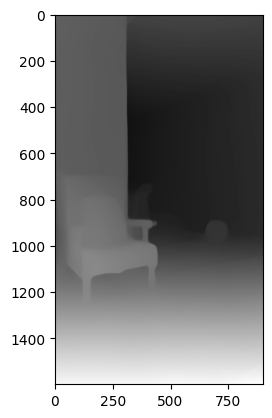

In [ ]:

print(np.shape(depth))
plt.imshow(depth,cmap='gray',vmin=0,vmax=255)

0
55


True

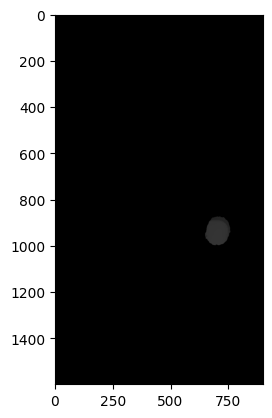

In [ ]:

depth_img=np.zeros((mask.shape[0],mask.shape[1],1))
depth_img=np.uint8(depth_img)*255

#plt.imshow(depth,cmap='gray')
img_array=np.array(image)


depth_img[x1,x2]=depth[x1,x2]
print(np.min(depth_img))
print(np.max(depth_img))
plt.imshow(depth_img,cmap='gray',vmin=0,vmax=255)
cv2.imwrite('depth_img.jpg',depth_img)

In [ ]:
# Calculate the average depth value for the object in the mask
object_depth = np.mean(depth_img[depth_img != 0])
print(depth_img[depth_img != 0])
print(object_depth)
# Determine whether the object is close or far based on its depth value
if object_depth > 60:
    print("The object is close")
else:
    print("The object is far")

[35 34 35 ... 54 54 55]
48.63336547733848
The object is far


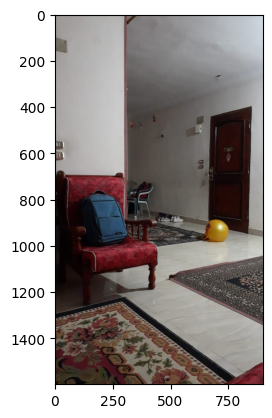

In [ ]:
plt.imshow(image)

## Final prediction :


*   List of objects detected using command prompt as text search
*   Depth estimation for each objects if found to tell if it's near OR far



[ 97  97  97 ... 121 121 121]
111.77805819852107
The backbag object is close
_________________________________________
[35 34 35 ... 54 54 55]
48.63336547733848
The yellow balloon object is far
_________________________________________
[]
nan
The pair of shoes is not found
_________________________________________
[40 40 40 ... 38 38 38]
37.08333236910616
The door object is far
_________________________________________
[ 97  97  97 ... 133 133 133]
110.58942741502618
The red chair object is close
_________________________________________


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


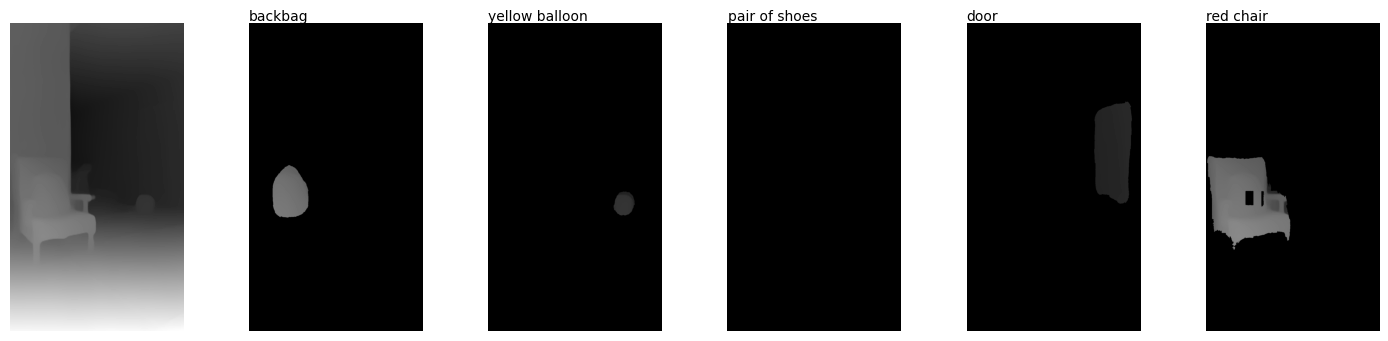

In [ ]:
# Display the original image and the heat map masks
fig, axs = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
axs[0].imshow(depth, cmap='gray',vmin=0,vmax=255)
axs[0].axis('off')
for i, prompt in enumerate(prompts):
    # Get the heat map for the prompt
    heat_map = torch.sigmoid(preds[i][0]).detach().cpu().numpy()
    # Resize the heat map to match the original image size
    heat_map_resized = cv2.resize(heat_map, (image.size[0], image.size[1]))
    # Apply a threshold to the heat map to get the mask
    mask = (heat_map_resized > 0.5).astype(np.uint8)
    # Apply the mask to the original image
    masked_depth = cv2.bitwise_and(np.array(depth), np.array(depth), mask=mask)
    # masked_depth = mask * np.array(depth)
    # Calculate the average depth value for the object in the mask
    object_depth = np.mean(masked_depth[masked_depth != 0])
    print(masked_depth[masked_depth != 0])
    print(object_depth)
    # Determine whether the object is close or far based on its depth value
    if np.count_nonzero(masked_depth) == 0:
        print(f"The {prompt} is not found")
    elif object_depth > 60:
        print(f"The {prompt} object is close")
    else:
        print(f"The {prompt} object is far")
    print("_________________________________________")
    # Display the masked image
    axs[i+1].imshow(masked_depth,cmap='gray',vmin=0,vmax=255)
    axs[i+1].axis('off')
    axs[i+1].text(0, -15, prompt)
plt.show()